# Merge and Inspect Dictionary Counts

- Author: Jaren Haber
- Institution: University of California, Berkeley
- Date created: October 7, 2019
- Date last modified: October 7, 2019
- Description: Merges counts of occurences of a dictionary (list of conceptually related terms) with existing data. Inspects numbers of webtext words, ratio of hits, and hit strength (log of ratio). 

## Import packages

In [45]:
import pandas as pd
import re
import numpy as np

root = "/home/jovyan/work/"

# For loading functions from files in data_tools directory:
import sys; sys.path.insert(0, root + "data_management/tools/")

In [46]:
# For displaying basic DF info, storing DFs for memory efficiency, and loading a filtered DF:
from df_tools import check_df, convert_df, load_filtered_df, replace_df_nulls

# For quickly loading & saving pickle files in Python:
from quickpickle import quickpickle_dump, quickpickle_load 

# For saving and loading text lists to/from file:
from textlist_file import write_list, load_list 

## Data management

### Load counting results, merge with stats data

In [15]:
# Load per entity, dictionary total counts:
countdf = pd.read_csv(root + 'charter_data/dict_counts/inquiry_counts_new_2015_250_v2a.csv', index_col="Unnamed: 0")
countdf

,NCESSCH,NUMWORDS,INQUIRY5_COUNT,INQUIRY5_RATIO,INQUIRY5_STR,INQUIRY20_NEW_COUNT,INQUIRY20_NEW_RATIO,INQUIRY20_NEW_STR,INQUIRY50_NEW_COUNT,INQUIRY50_NEW_RATIO,INQUIRY50_NEW_STR,INQUIRY49_NEW_HANDSOFF_COUNT,INQUIRY49_NEW_HANDSOFF_RATIO,INQUIRY49_NEW_HANDSOFF_STR
0,1.001970e+10,17929.0,0.0,0.0,0.0,2.0,0.000112,0.112171,9.0,0.000502,0.235109,7.0,0.000391,0.212323
1,2.000010e+10,0.0,0.0,NaN,-0.0,0.0,NaN,-0.000000,0.0,NaN,-0.000000,0.0,NaN,-0.000000
2,2.001500e+10,1330.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,2.001500e+10,28279.0,0.0,0.0,0.0,1.0,0.000035,0.067625,13.0,0.000460,0.257484,11.0,0.000389,0.242442
4,2.001800e+10,563.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10960,7.200030e+11,0.0,0.0,NaN,-0.0,0.0,NaN,-0.000000,0.0,NaN,-0.000000,0.0,NaN,-0.000000
10961,7.200030e+11,0.0,0.0,NaN,-0.0,0.0,NaN,-0.000000,0.0,NaN,-0.000000,0.0,NaN,-0.000000
10962,7.200030e+11,0.0,0.0,NaN,-0.0,0.0,NaN,-0.000000,0.0,NaN,-0.000000,0.0,NaN,-0.000000
10963,7.200030e+11,0.0,0.0,NaN,-0.0,0.0,NaN,-0.000000,0.0,NaN,-0.000000,0.0,NaN,-0.000000


In [32]:
# Load stats data:
statsdf = pd.read_csv(root + 'misc_data/backups/charters_stats_2015_v2a.csv', low_memory = False)
statsdf.drop(columns = ['numwords', 'inquirycount', 'disciplinecount', 'inquiryprop', 'disciplineprop'], inplace = True)
statsdf

,traditionalprop,progressiveprop,numpages,reading1314,math1314,reading1415,math1415,reading1516,math1516,reading1617,...,ethnicisolated90,ethnicisolated80,ethnicisolated70,collegesd,popdensity,unemployment,foreignborn,closerate,publicdensity,charterdensity
0,NaN,NaN,0,65-69,65-69,15-19,20-24,NaN,NaN,15-19,...,1,1,1,12.06,0.706206,18.30,2.03,0.000000,28,1
1,0.000000,0.000752,1,85-89,80-84,40-44,40-44,NaN,NaN,45-49,...,1,1,1,23.77,2.822938,7.57,8.18,0.111111,10,2
2,0.000212,0.000177,117,75-79,55-59,50-54,35-39,NaN,NaN,40-44,...,1,1,1,23.77,2.822938,7.57,8.18,0.111111,10,2
3,0.000000,0.000000,1,GE95,GE95,70-74,65-69,NaN,NaN,70-74,...,1,1,1,34.30,175.587500,6.05,10.29,0.000000,101,9
4,NaN,NaN,0,86,66,54,31,NaN,NaN,50,...,1,1,1,34.30,175.587500,6.05,10.29,0.000000,101,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,NaN,NaN,0,77,62,62,39,54,23,65,...,1,1,1,24.57,1030.846000,17.70,2.70,0.130112,1467,113
6943,NaN,NaN,0,20-24,LE5,45-49,LE5,55-59,LE5,NaN,...,1,1,1,24.57,1030.846000,17.70,2.70,0.130112,1467,113
6944,NaN,NaN,0,56,2,44,3,57,6,50,...,1,1,1,24.57,1030.846000,17.70,2.70,0.130112,1467,113
6945,NaN,NaN,0,36,LE1,35,LE1,48,4,42,...,1,1,1,24.57,1030.846000,17.70,2.70,0.130112,1467,113


In [42]:
# Merge new counts with stats data:
df_new = pd.merge(statsdf, countdf, how = "left", left_on = "NCESSCH", right_on = "NCESSCH")
df_new

,traditionalprop,progressiveprop,numpages,reading1314,math1314,reading1415,math1415,reading1516,math1516,reading1617,...,INQUIRY5_STR,INQUIRY20_NEW_COUNT,INQUIRY20_NEW_RATIO,INQUIRY20_NEW_STR,INQUIRY50_NEW_COUNT,INQUIRY50_NEW_RATIO,INQUIRY50_NEW_STR,INQUIRY49_NEW_HANDSOFF_COUNT,INQUIRY49_NEW_HANDSOFF_RATIO,INQUIRY49_NEW_HANDSOFF_STR
0,NaN,NaN,0,65-69,65-69,15-19,20-24,NaN,NaN,15-19,...,-0.0,0.0,NaN,-0.000000,0.0,NaN,-0.000000,0.0,NaN,-0.000000
1,0.000000,0.000752,1,85-89,80-84,40-44,40-44,NaN,NaN,45-49,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000
2,0.000212,0.000177,117,75-79,55-59,50-54,35-39,NaN,NaN,40-44,...,0.0,1.0,0.000035,0.067625,13.0,0.00046,0.257484,11.0,0.000389,0.242442
3,0.000000,0.000000,1,GE95,GE95,70-74,65-69,NaN,NaN,70-74,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000
4,NaN,NaN,0,86,66,54,31,NaN,NaN,50,...,-0.0,0.0,NaN,-0.000000,0.0,NaN,-0.000000,0.0,NaN,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,NaN,NaN,0,77,62,62,39,54,23,65,...,-0.0,0.0,NaN,-0.000000,0.0,NaN,-0.000000,0.0,NaN,-0.000000
6943,NaN,NaN,0,20-24,LE5,45-49,LE5,55-59,LE5,NaN,...,-0.0,0.0,NaN,-0.000000,0.0,NaN,-0.000000,0.0,NaN,-0.000000
6944,NaN,NaN,0,56,2,44,3,57,6,50,...,-0.0,0.0,NaN,-0.000000,0.0,NaN,-0.000000,0.0,NaN,-0.000000
6945,NaN,NaN,0,36,LE1,35,LE1,48,4,42,...,-0.0,0.0,NaN,-0.000000,0.0,NaN,-0.000000,0.0,NaN,-0.000000


In [43]:
# Rename new columns:
df_new.rename(columns = {
 'traditionalprop' : 'traditional_prop', 
 'progressiveprop' : 'progressive_prop', 
 'NUMWORDS' : 'numwords', 
 'INQUIRY5_COUNT' : 'inquiry_seed_count',
 'INQUIRY5_RATIO' : 'inquiry_seed_prop',
 'INQUIRY5_STR' : 'inquiry_seed_log',
 'INQUIRY20_NEW_COUNT' : 'inquiry_narrow_count',
 'INQUIRY20_NEW_RATIO' : 'inquiry_narrow_prop',
 'INQUIRY20_NEW_STR' : 'inquiry_narrow_log',
 'INQUIRY50_NEW_COUNT' : 'inquiry_full_count',
 'INQUIRY50_NEW_RATIO' : 'inquiry_full_prop',
 'INQUIRY50_NEW_STR' : 'inquiry_full_log',
 'INQUIRY49_NEW_HANDSOFF_COUNT' : 'inquiry_full_nohands_count',
 'INQUIRY49_NEW_HANDSOFF_RATIO' : 'inquiry_full_nohands_prop',
 'INQUIRY49_NEW_HANDSOFF_STR' : 'inquiry_full_nohands_log'}, 
              inplace = True)

# Reorder columns:
df_new = df_new[['inquiry_seed_count', 'inquiry_seed_prop', 'inquiry_seed_log', 
          'inquiry_narrow_count', 'inquiry_narrow_prop', 'inquiry_narrow_log', 
          'inquiry_full_count', 'inquiry_full_prop', 'inquiry_full_log', 
          'inquiry_full_nohands_count', 'inquiry_full_nohands_prop', 'inquiry_full_nohands_log', 
          'traditional_prop', 'progressive_prop',
          'numwords', 'numpages', 
          'reading1314', 'math1314', 'reading1415', 'math1415', 'reading1516', 'math1516', 'reading1617', 'math1617', 
          'pocschool', 'pocschoolcount', 'povertyschool', 'povertyschoolcount', 'pocsd', 'povertysd', 'childpovertysd', 
          'students', 'age', 'state', 'cmo', 'cmoname', 'titlei', 'urban', 
          'primary', 'middle', 'high', 'otherlevel', 'level', 
          'expulsions', 'suspensions', 'incidents', 'lawreferrals', 
          'lepcount', 'disabledcount', 'approgram', 'teachersccd', 'teacherscrdc', 'certcount', 'certrate', 
          'geodistrict', 'numpdfs', 'NCESSCH', 
          'ethnicisolated99', 'ethnicisolated95', 'ethnicisolated90', 'ethnicisolated80', 'ethnicisolated70', 
          'collegesd', 'popdensity', 'unemployment', 'foreignborn', 'closerate', 'publicdensity', 'charterdensity']]

list(df_new)

['inquiry_seed_count',
 'inquiry_seed_prop',
 'inquiry_seed_log',
 'inquiry_narrow_count',
 'inquiry_narrow_prop',
 'inquiry_narrow_log',
 'inquiry_full_count',
 'inquiry_full_prop',
 'inquiry_full_log',
 'inquiry_full_nohands_count',
 'inquiry_full_nohands_prop',
 'inquiry_full_nohands_log',
 'traditional_prop',
 'progressive_prop',
 'numwords',
 'numpages',
 'reading1314',
 'math1314',
 'reading1415',
 'math1415',
 'reading1516',
 'math1516',
 'reading1617',
 'math1617',
 'pocschool',
 'pocschoolcount',
 'povertyschool',
 'povertyschoolcount',
 'pocsd',
 'povertysd',
 'childpovertysd',
 'students',
 'age',
 'state',
 'cmo',
 'cmoname',
 'titlei',
 'urban',
 'primary',
 'middle',
 'high',
 'otherlevel',
 'level',
 'expulsions',
 'suspensions',
 'incidents',
 'lawreferrals',
 'lepcount',
 'disabledcount',
 'approgram',
 'teachersccd',
 'teacherscrdc',
 'certcount',
 'certrate',
 'geodistrict',
 'numpdfs',
 'NCESSCH',
 'ethnicisolated99',
 'ethnicisolated95',
 'ethnicisolated90',
 'ethn

In [44]:
df_new.to_csv(root + 'charter_data/charters_stats_2015_v2a_counts_inqnew.csv', index = False, encoding = "utf-8")

## Combine URLs and stats charter data (no counts or topics for now)

In [80]:
urldf = pd.read_csv(root + '/misc_data/backups/charter_URLs_2016.csv')
urldf = urldf[["URL","NCESSCH"]]
racedf = statsdf[['pocschool', 'pocschoolcount', 'povertyschool', 'povertyschoolcount',
                 'white_students', 'asian_students', 'black_students', 'native_students', 'hispanic_students', 'mixed_students',
                 'pocsd', 'povertysd', 
                 'white_district', 'black_district', 'asian_district', 'native_district', 'mixed_district', 'hispanic_district',
                 'students', 'age', 'state', 'cmo', 'cmoname', 'urban', 'primary', 'middle', 'high', 'otherlevel', 'level',
                 'geodistrict', 'numpdfs', 'NCESSCH']]
urldf = pd.merge(urldf, racedf, how="right", on="NCESSCH")
urldf.drop(columns = ['students', 'age', 'state', 'cmo', 'cmoname', 'urban', 'primary', 'middle', 'high', 'otherlevel',
                      'level', 'geodistrict', 'numpdfs'], inplace=True)
urldf.rename(columns = {'pocschool':'pocschoolprop', 'povertyschool':'povertyschoolprop'}, inplace = True)
list(urldf)

['URL',
 'NCESSCH',
 'pocschoolprop',
 'pocschoolcount',
 'povertyschoolprop',
 'povertyschoolcount',
 'white_students',
 'asian_students',
 'black_students',
 'native_students',
 'hispanic_students',
 'mixed_students',
 'pocsd',
 'povertysd',
 'white_district',
 'black_district',
 'asian_district',
 'native_district',
 'mixed_district',
 'hispanic_district']

In [81]:
urldf.to_csv(root + '/swarm/data/charters_stats_notext.csv')

## Inspect results

In [48]:
# Show the distribution for strength. Notice there are many -6, which is due to many zeroes in hit count:
%matplotlib inline
import matplotlib.pyplot as plt
count = df_new['inquiry_full_count']
emphasis = df_new['inquiry_full_log']

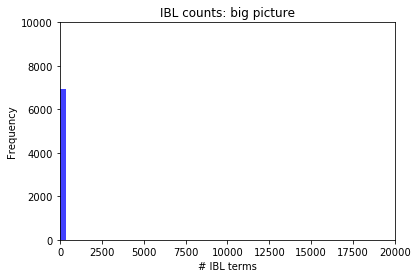

In [49]:
n, bins, patches = plt.hist(count, 50, facecolor='b', alpha=0.75) # build histogram
plt.ylabel('Frequency')
plt.xlabel('# IBL terms')
plt.grid(False)
plt.title('IBL counts: big picture')
plt.xlim(0, 20000)
plt.ylim(0, 10000)
plt.show()

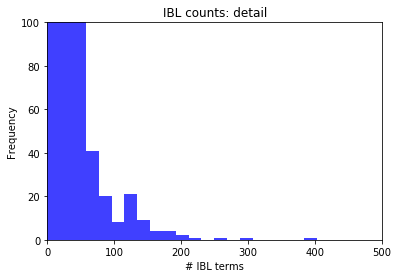

In [50]:
n, bins, patches = plt.hist(count, 1000, facecolor='b', alpha=0.75) # build histogram
plt.ylabel('Frequency')
plt.xlabel('# IBL terms')
plt.grid(False)
plt.title('IBL counts: detail')
plt.xlim(0, 500)
plt.ylim(0, 100)
plt.show()

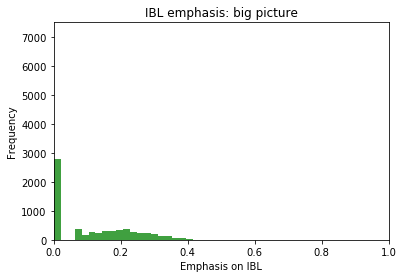

In [54]:
n, bins, patches = plt.hist(emphasis, 30, facecolor='g', alpha=0.75) # build histogram
plt.ylabel('Frequency')
plt.xlabel('Emphasis on IBL')
plt.grid(False)
plt.title('IBL emphasis: big picture')
plt.xlim(0, 1)
plt.ylim(0, 7500)
plt.show()

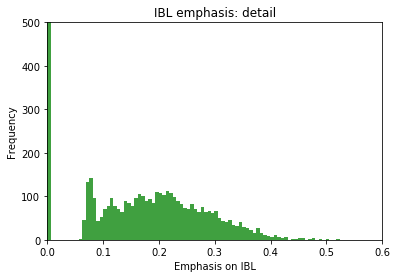

In [59]:
n, bins, patches = plt.hist(emphasis, 100, facecolor='g', alpha=0.75) # build histogram
plt.title('IBL emphasis: detail')
plt.ylabel('Frequency')
plt.xlabel('Emphasis on IBL')
plt.grid(False)
plt.xlim(0, 0.6)
plt.ylim(0, 500)
plt.show()

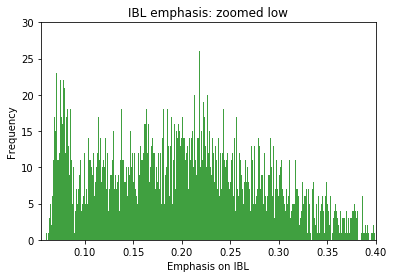

In [65]:
n, bins, patches = plt.hist(emphasis, 800, facecolor='g', alpha=0.75) # build histogram
plt.title('IBL emphasis: zoomed low')
plt.ylabel('Frequency')
plt.xlabel('Emphasis on IBL')
plt.grid(False)
plt.xlim(0.055, 0.40)
plt.ylim(0, 30)
plt.show()